In [1]:
%matplotlib inline 
import pickle
import os
import numpy as np
import json
from PIL import Image,ImageDraw
import sys

import cv2
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import find_contours

from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box

In [2]:
from random import sample

In [3]:
imagePath = r'C:\Users\jiali\Desktop\choroColorRead\generatedMaps\quantiles'
imageName = 'ohio_Blues_4_pos_large.jpg'
# testImages = os.listdir(imagePath)

In [4]:
# read detection results from pickle file
detectResultsPath = r'D:\OneDrive - The Ohio State University\choroColorRead'
detectResultFileName = 'detectResultSpatialPattern.pickle'
with open(detectResultsPath + '\\' + detectResultFileName, 'rb') as f:
    detectResults = pickle.load(f)

In [5]:
detectResult = detectResults[4]

In [6]:
property = detectResult[1]
boxes = property['rois']
masks = property['masks']
class_ids = property['class_ids']

# extract mask for mapping area
N = boxes.shape[0]
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

image = cv2.imread(imagePath + '\\' + imageName)
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

masked_image = image.astype(np.uint32).copy()
maskPolyList = []

In [7]:
image.shape

(966, 1576, 3)

In [8]:
height = image.shape[0]
print(height)
width = image.shape[1]
print(width)

966
1576


In [9]:
# get the polygon for mapping area
for i in range(N):
#     if i > 0:
#         continue
    if class_ids[i] != 3:
        continue
    # Bounding box
    if not np.any(boxes[i]):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        continue
    y1, x1, y2, x2 = boxes[i]
    bboxMap = box(x1, y1, x2, y2)
    # Mask
    mask = masks[:, :, i]

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        vertList = [(vert[0],vert[1]) for vert in verts]
        maskPolygon = Polygon(vertList)
        maskPolyList.append(maskPolygon)

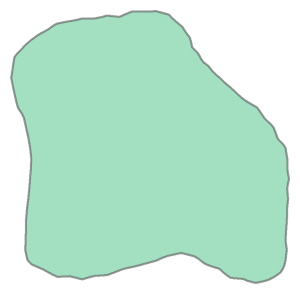

In [10]:
maskPolygon

In [11]:
# rgb color list
colorList = [[191, 214, 230], [107, 174, 216], [33, 114, 180], [239, 243, 255]]
# colorList = [[191, 214, 230], [107, 174, 216], [33, 114, 180], [239, 243, 255]]

In [13]:
with open(r'C:\Users\jiali\Desktop\choroColorRead\colorRecognitionEvaluation' + '\\' + 'colorsOrderedImagesRemoveGrey3.pickle', 'rb') as f:
    colorsOrderedImages = pickle.load(f)

In [14]:
colorList = colorsOrderedImages[imageName]
colorList

[[33, 114, 180], [107, 174, 216], [191, 214, 230], [239, 243, 255]]

In [15]:
def bgr2rgb(value):
    return value[2],value[0],value[1]
def valueEqualColor(value,color):
    colorR, colorG, colorB = color[0], color[1], color[2]
    valueR, valueG, valueB = value[0], value[1], value[2]
    if abs(colorR - valueR) > 10 or abs(colorB - valueB) > 10 or abs(colorG - valueG) > 10:
        return False
    else:
        return True

In [16]:
def rgb2Grey(dominantColor):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    dominantColorGrey = int(np.dot(dominantColor, rgb_weights))
    return dominantColorGrey

In [17]:
# traverse the whole image
colorGrey0 = rgb2Grey(colorList[0])
colorGrey1 = rgb2Grey(colorList[1])
colorGrey2 = rgb2Grey(colorList[2])
colorGrey3 = rgb2Grey(colorList[3])

In [18]:
pixelCoordList0, pixelCoordList1, pixelCoordList2, pixelCoordList3 = [],[],[],[]
for i in range(height):
    if i % 100 == 0:
        print(i)
    for j in range(mask.shape[1]):
        
        point = Point(j,i)
#         if bboxMap.contains(point) and maskPolygon.contains(point):
        if mask[i,j] == True:
#             print('yes!')
            value =  imageGray[i,j]
#             print(value)
            b, g, r = image[i,j]
#             value_rgb = value
#             print(value_rgb)
#             if not (abs(b - g) < 10 and abs(b-r) < 10 and abs(g - r)<10):
#                 if abs(value - colorGrey0) <= 10:
# #                     print('0: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList0.append((j,i))  
#                 elif abs(value - colorGrey1) <= 10:
# #                     print('1: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList1.append((j,i))  
#                 elif abs(value - colorGrey2) <= 10:
# #                     print('0: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList2.append((j,i))  
#                 elif abs(value - colorGrey3) <= 10:
# #                     print('0: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList3.append((j,i))  
            if not (abs(int(b) - int(g)) < 10 and abs(int(b)-int(r)) < 10 and abs(int(g) - int(r))<10):
                if (abs(int(b) - colorList[0][2]) < 10 and abs(int(g) - colorList[0][1]) < 10 and abs(int(r) -colorList[0][0])<10):
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList0.append((j,i))  
                elif (abs(int(b) - colorList[1][2]) < 10 and abs(int(g) - colorList[1][1]) < 10 and abs(int(r) -colorList[1][0])<10):
#                     print('1: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList1.append((j,i))  
                elif (abs(int(b) - colorList[2][2]) < 10 and abs(int(g) - colorList[2][1]) < 10 and abs(int(r) -colorList[2][0])<10):
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList2.append((j,i))  
                elif (abs(int(b) - colorList[3][2]) < 10 and abs(int(g) - colorList[3][1]) < 10 and abs(int(r) -colorList[3][0])<10):
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList3.append((j,i))

0
100
200
300
400
500
600
700
800
900


In [19]:
pixelCoordList0_sample = sample(pixelCoordList0,int(len(pixelCoordList0)/100))
pixelCoordList1_sample = sample(pixelCoordList1,int(len(pixelCoordList1)/100))
pixelCoordList2_sample = sample(pixelCoordList2,int(len(pixelCoordList2)/100))
pixelCoordList3_sample = sample(pixelCoordList3,int(len(pixelCoordList3)/100))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

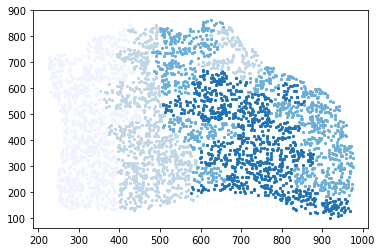

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in pixelCoordList0_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList0_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[0])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList1_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList1_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[1])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList2_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList2_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[2])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList3_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList3_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[3])/255.0)
plt.show()

In [21]:
def moransi(z, w):
    """
    Input
      z: list of values
      w: weight matrix
    Output
      I: Moran's I measure
    """
    n = len(z)
    mean = float(sum(z))/n
    S0 = 0
    d = 0
    var = 0
    for i in range(n):
        var += (z[i]-mean)**2
        for j in range(i):
            if w[i][j]:
                S0 += w[i][j]
                d += w[i][j] * (z[i]-mean) * (z[j]-mean)
    I = n*d/S0/var
    return I

In [22]:
len0 = len(pixelCoordList0_sample)
len1 = len(pixelCoordList1_sample)
len2 = len(pixelCoordList2_sample)
len3 = len(pixelCoordList3_sample)

In [23]:
zList0 = [0 for i in range(len0)]
zList1 = [1 for i in range(len1)]
zList2 = [2 for i in range(len2)]
zList3 = [3 for i in range(len3)]

In [24]:
# attribute list and coordinate list
zList = zList0 + zList1 + zList2 + zList3
pixelCoordList_sample = pixelCoordList0_sample + pixelCoordList1_sample + pixelCoordList2_sample + pixelCoordList3_sample

In [25]:
wMatrix = np.zeros(shape=(len(zList), len(zList)))

In [26]:
import math

In [27]:
def distance(coord1, coord2):
    x1, y1 = coord1[0], coord1[1]
    x2, y2 = coord2[0], coord2[1]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [28]:
# 1/(distance(pixelCoordList_sample[i], pixelCoordList_sample[j]) + 0.0000001)
def calculateKNeighWeight(i, coordList, k = 6): 
    # i is the currently target, k includes the point itself
    # k nearest neighborhood, only consider the k nearest neighbors
    # based on distance to calcuate weight, and normalize weight
    distList = []
    for j in range(len(coordList)):
        dist = distance(coordList[i], coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
    distNeigh = [distList[ind] for ind in neighIndice]

    neighIndice = neighIndice[1:]
    distNeigh = distNeigh[1:]
    wNeigh = [1/(distNeigh[j]+ 0.00000001) for j in range(len(distNeigh))]
    
    # normalize weights
    wNeighNorm = (np.asarray(wNeigh)/sum(wNeigh)).tolist()
    
    # put weights together
    wList = [0 for j in range(len(coordList))]
    for ind, j in enumerate(neighIndice):
        wList[j] = wNeighNorm[ind]
        
    return wList

In [29]:
for i in range(len(pixelCoordList_sample)):
    if i % 100 == 0:
        print(i)
    wMatrix[i] = calculateKNeighWeight(i, pixelCoordList_sample)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700


In [30]:
sum([201, 0, 32])

233

In [31]:
sum([7, 112, 177])

296

In [32]:
w = wMatrix.tolist()

In [33]:
moransi(zList, w)

0.9889744124184331

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [35]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList0_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans0 = KMeans(n_clusters = numClusters).fit(x)
kmeans0.cluster_centers_

[0.4523384472130172, 0.4147012365948714, 0.408083210453338, 0.42157800147050656, 0.4093802283339487, 0.4080142210158594, 0.41035719634127643, 0.40865508677004303, 0.403969570115868, 0.41405876810208603, 0.42260476970808963, 0.4275607372690405, 0.42469745270407266, 0.4225027233013347, 0.42551237734502523, 0.4240047328577542, 0.421368807000231, 0.41023465517318397, 0.4168048504587002, 0.41504899269075696, 0.40290877037984446, 0.3975747984078804, 0.39857565775765286, 0.3957331208103621, 0.40300302052745096, 0.40371826981668724, 0.4015312084242519, 0.4003648810863516, 0.39832662715908584, 0.396880020711968, 0.39851936579143377, 0.3822255215916458, 0.39986712522533846, 0.37811655655122883, 0.3939176678312007, 0.36417824768198903, 0.37792224697425447, 0.3799217443229485, 0.3890412848695219, 0.37685929006327057, 0.3788993815133648, 0.3852019081119914, 0.3799740832514057, 0.38949564591963143, 0.37793603973081885, 0.3839764705060833, 0.3861274517630055, 0.37912318766293474, 0.37969061438593993,

array([[776.21428571, 265.36706349],
       [683.99105145, 524.04026846]])

In [36]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList1_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans1 = KMeans(n_clusters = numClusters).fit(x)
kmeans1.cluster_centers_

[0.5298976932492039, 0.5813670355643128, 0.5323457520873852, 0.49047137089200243, 0.5076724343869743, 0.5064236398076695, 0.4841303706165103, 0.47037082184141443, 0.47120088078735195, 0.46196990816609745, 0.473880312759027, 0.4541640069496878, 0.4497306108165835, 0.4556588948888855, 0.46212722436796433, 0.46459001233901387, 0.45928290363139035, 0.46279577904948155, 0.4721382019198814, 0.46787654343573293, 0.47140602524039077, 0.46441982675539456, 0.4624222270804001, 0.4582210976621375, 0.4376699291672525, 0.45661077582938125, 0.4427260643466356, 0.4312061396586661, 0.4383743929247909, 0.4419024843992242, 0.4195953644405951, 0.42505952498825017, 0.4189735774185657, 0.4307918873780371, 0.4104412965286918, 0.4130676965713193, 0.4049954948962149, 0.4084269500492607, 0.4019442064692079, 0.4044442893354168, 0.4047946945386868, 0.3972107888117417, 0.3962040168968936, 0.40390572590936313, 0.4079175853942823, 0.3994340119878725, 0.3998454371240789, 0.3973996937424455, 0.3981925826488184, 0.3970

array([[892.70021882, 404.11597374],
       [592.56346749, 712.99380805],
       [603.09036145, 389.74698795]])

In [37]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList2_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans2 = KMeans(n_clusters = numClusters).fit(x)
kmeans2.cluster_centers_

[0.5742810415223493, 0.4836283282451134, 0.4815834140260791, 0.46396760469313125, 0.46664472510392596, 0.44235129028642056, 0.4429553461517175, 0.4299614964525701, 0.4251426820141942, 0.4235342957318837, 0.4282042897000084, 0.42993105597544223, 0.41876724815927185, 0.4248815654009042, 0.4268432280202656, 0.41430691517803064, 0.4241822454273594, 0.4173359001405791, 0.4183216932294024, 0.41034564960597086, 0.41568494001426287, 0.40954812543313096, 0.4075007118375296, 0.4058696045227284, 0.4071539990165513, 0.40075376001530594, 0.40291268261545965, 0.38923734829011053, 0.40288185878112714, 0.39471526756610853, 0.39325626537195524, 0.3913907128660859, 0.39318359153484317, 0.394500881145726, 0.3936611610847691, 0.393476493030995, 0.3978388876687059, 0.384877098420122, 0.39688660875290277, 0.3944716314528507, 0.3890549572296465, 0.38118396764399026, 0.38616718292235996, 0.39003860713925476, 0.392713760725595, 0.3836157609741762, 0.3819515180465545, 0.3900900479953944, 0.38331368882536104, 0.

array([[477.96577947, 306.57604563],
       [525.06872038, 675.51421801]])

In [38]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList3_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans3 = KMeans(n_clusters = numClusters).fit(x)
kmeans3.cluster_centers_

[0.4897883614440312, 0.4376463215927196, 0.41228800038765273, 0.4003721462954891, 0.37067654075773115, 0.3998015230162389, 0.3998679441131939, 0.4158780791325398, 0.4185481713271587, 0.4202431937709634, 0.4151570294337625, 0.4146378056660745, 0.4103519308465218, 0.4046480606888319, 0.40011981903703003, 0.401638232058845, 0.4024087168269074, 0.3925574979771358, 0.3905433789215809, 0.38782051669683776, 0.3896290927302942, 0.38457030863255576, 0.384714999059013, 0.3846065016145583, 0.3836497366270563, 0.3814535111198799, 0.3786158135539992, 0.3889499448777587, 0.3823230933159484, 0.3793851192735682, 0.37551832374566924, 0.38295333329303394, 0.3759442874693907, 0.3794925257484045, 0.38031765306472415, 0.37840441147744996, 0.3861991511560025, 0.3726912863827755, 0.383938406474087, 0.3814802642274532, 0.38514597379213733, 0.38513283916238134, 0.3764999759814434, 0.38547271227984586, 0.369250678296953, 0.3785480676242669, 0.37882404783428564, 0.3848069123691075, 0.38788818540041387, 0.3805788

array([[328.35810811, 618.28603604],
       [319.72340426, 288.95271868]])

In [39]:
kmeans3.cluster_centers_.shape

(2, 2)

###  find the cluster with fewest points and calculate number of clusters for each pixel category based on the min number of points in a cluster

In [172]:
# find the cluster with fewest points
numCluster0 = kmeans0.cluster_centers_.shape[0]
numPointInClusterList = []
for i in range(0,numCluster0):
    labelList = kmeans0.labels_.tolist()
    numPointInCluster = labelList.count(i)
#     print(numPointInCluster)
    numPointInClusterList.append(numPointInCluster)
for i in range(0,kmeans1.cluster_centers_.shape[0]):
    labelList = kmeans1.labels_.tolist()
    numPointInCluster = labelList.count(i)
#     print(numPointInCluster)
    numPointInClusterList.append(numPointInCluster)
for i in range(0,kmeans2.cluster_centers_.shape[0]):
    labelList = kmeans2.labels_.tolist()
    numPointInCluster = labelList.count(i)
#     print(numPointInCluster)
    numPointInClusterList.append(numPointInCluster)
for i in range(0,kmeans3.cluster_centers_.shape[0]):
    labelList = kmeans3.labels_.tolist()
    numPointInCluster = labelList.count(i)
#     print(numPointInCluster)
    numPointInClusterList.append(numPointInCluster)
minNumPointInCluster = min(numPointInClusterList)

In [173]:
# based on the min number of points in a cluster, calculate number of clusters for each pixel category
numCluster0 = math.ceil(len(pixelCoordList0_sample)/ minNumPointInCluster)
print(numCluster0)
numCluster1 = math.ceil(len(pixelCoordList1_sample)/ minNumPointInCluster)
print(numCluster1)
numCluster2 = math.ceil(len(pixelCoordList2_sample)/ minNumPointInCluster)
print(numCluster2)
numCluster3 = math.ceil(len(pixelCoordList3_sample)/ minNumPointInCluster)
print(numCluster3)

5
6
6
5


In [182]:
kmeans0 = KMeans(n_clusters = numCluster0).fit(pixelCoordList0_sample)
kmeans1 = KMeans(n_clusters = numCluster1).fit(pixelCoordList1_sample)
kmeans2 = KMeans(n_clusters = numCluster2).fit(pixelCoordList2_sample)
kmeans3 = KMeans(n_clusters = numCluster3).fit(pixelCoordList3_sample)

In [40]:
zCenters0 = [0 for i in range(kmeans0.cluster_centers_.shape[0])]
zCenters1 = [1 for i in range(kmeans1.cluster_centers_.shape[0])]
zCenters2 = [2 for i in range(kmeans2.cluster_centers_.shape[0])]
zCenters3 = [3 for i in range(kmeans3.cluster_centers_.shape[0])]

In [41]:
coordCenters0 = kmeans0.cluster_centers_.tolist()
coordCenters1 = kmeans1.cluster_centers_.tolist()
coordCenters2 = kmeans2.cluster_centers_.tolist()
coordCenters3 = kmeans3.cluster_centers_.tolist()

In [42]:
zCenters = zCenters0 + zCenters1 + zCenters2 + zCenters3
coordCenters = coordCenters0 + coordCenters1 + coordCenters2 + coordCenters3

In [43]:
wMatrix = np.zeros(shape=(len(zCenters), len(zCenters)))

In [44]:
for i in range(len(zCenters)):
    wMatrix[i] = calculateKNeighWeight(i, coordCenters)
    print(wMatrix[i])

[0.         0.18807438 0.28509743 0.         0.24228926 0.17154552
 0.         0.         0.11299341]
[0.15499873 0.         0.17683504 0.20278151 0.27150333 0.
 0.19388139 0.         0.        ]
[0.31024534 0.23349725 0.         0.13050245 0.19383351 0.13192145
 0.         0.         0.        ]
[0.         0.17815801 0.         0.         0.11563125 0.08856338
 0.48440322 0.13324414 0.        ]
[0.19108358 0.25981598 0.14047729 0.         0.         0.27111481
 0.13750835 0.         0.        ]
[0.14769332 0.14844295 0.         0.         0.29596851 0.
 0.         0.12861122 0.27928401]
[0.         0.1600806  0.         0.45523179 0.11864268 0.09449322
 0.         0.17155171 0.        ]
[0.         0.         0.         0.20750859 0.16297415 0.16844606
 0.2842873  0.         0.17678391]
[0.         0.13385457 0.         0.         0.19294925 0.36447103
 0.13257718 0.17614797 0.        ]


In [45]:
w = wMatrix.tolist()
moransi(zCenters, w)

0.20722884005893807

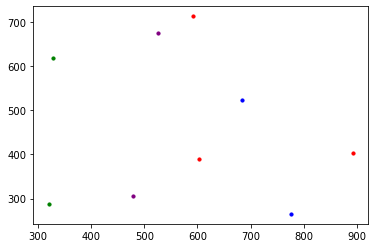

In [46]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in coordCenters0]
yList = [pixelCoord[1] for pixelCoord in coordCenters0]
ax.scatter(xList, yList, s = 10,c = 'blue')

xList = [pixelCoord[0] for pixelCoord in coordCenters1]
yList = [pixelCoord[1] for pixelCoord in coordCenters1]
ax.scatter(xList, yList, s = 10,c = 'red')

xList = [pixelCoord[0] for pixelCoord in coordCenters2]
yList = [pixelCoord[1] for pixelCoord in coordCenters2]
ax.scatter(xList, yList, s = 10,c = 'purple')

xList = [pixelCoord[0] for pixelCoord in coordCenters3]
yList = [pixelCoord[1] for pixelCoord in coordCenters3]
ax.scatter(xList, yList, s = 10,c = 'green')
plt.show()

### try to use the random lines to get number of clusters

#### first use a horizontal line as a prototype

In [47]:
pixelCoordList_sample[0]

(714, 279)

In [48]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

(225, 976, 101, 862, 481)

In [49]:
def calculateKNeigh(targetCoord, coordList, k = 6): 
    # targetCoord is the coordinate of current point
    # k nearest neighborhood, only consider the k nearest neighbors
    # CoordList is the set of coordinates to compare
    distList = []
    for j in range(len(coordList)):
        dist = distance(targetCoord, coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
#     [distList[ind] for ind in neighIndice]

    return neighIndice

In [50]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [51]:
def mostCommonListHLine(y,xMin, xMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for x in range(xMin, xMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [52]:
def mostCommonListVLine(x,yMin, yMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for y in range(yMin, yMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [54]:
mostCommonListLines = []
for y in range(yMin, yMax + 1, int((yMax + 1 - yMin) / 10)):
    print(y)
    mostCommonList = mostCommonListHLine(y, xMin, xMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

101
177
253
329
405
481
557
633
709
785
861


In [55]:
for x in range(xMin, xMax + 1, int((xMax + 1 - xMin) / 10)):
    print(x)
    mostCommonList = mostCommonListVLine(x, yMin, yMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

225
300
375
450
525
600
675
750
825
900
975


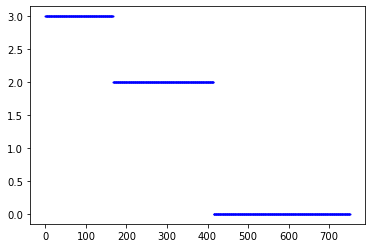

In [56]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [i for i in range(len(mostCommonListLines[0]))]
yList = mostCommonListLines[0]
ax.scatter(xList, yList, s = 1,c = 'blue')

In [57]:
def countSegmentationFun(mostCommonList):
    countSegmentation = 1
    currentValue = mostCommonList[0]
    countDifferentTemp = 0
    for i in range(len(mostCommonList)):
        if mostCommonList[i] ==  currentValue:
            countDifferentTemp = 0
            continue
        else:
            countDifferentTemp += 1
            if countDifferentTemp > 20:
                currentValue = mostCommonList[i]
                countSegmentation += 1
    return countSegmentation

In [58]:
countSegmentationList = []
for mostCommonList in mostCommonListLines:
    countSegmentation = countSegmentationFun(mostCommonList)
    countSegmentationList.append(countSegmentation)
countSegmentationList

[3, 3, 5, 4, 5, 5, 4, 7, 5, 5, 5, 1, 1, 5, 3, 4, 8, 4, 3, 5, 3, 2]

In [80]:
import statistics
statistics.median(countSegmentationList)

4.0

In [59]:
countSegmentation = max(countSegmentationList)
totalNumCluster = countSegmentation**2
numClusterEach = math.ceil(totalNumCluster / 4)
print(numClusterEach)
numCluster0, numCluster1, numCluster2, numCluster3 = numClusterEach,numClusterEach,numClusterEach,numClusterEach

16


In [60]:
kmeans0 = KMeans(n_clusters = numCluster0).fit(pixelCoordList0_sample)
kmeans0.cluster_centers_

array([[808.40909091, 431.79545455],
       [773.475     , 260.9375    ],
       [548.9       , 530.45      ],
       [924.29032258, 143.66129032],
       [726.14754098, 315.3442623 ],
       [699.37037037, 572.14814815],
       [636.39240506, 511.26582278],
       [833.93846154, 339.01538462],
       [610.41176471, 213.35294118],
       [734.01234568, 488.54320988],
       [624.7012987 , 619.27272727],
       [833.22972973, 182.86486486],
       [642.20634921, 344.06349206],
       [809.35897436, 573.64102564],
       [690.98039216, 233.76470588],
       [731.984375  , 391.390625  ]])

In [61]:
kmeans1 = KMeans(n_clusters = numCluster1).fit(pixelCoordList1_sample)
kmeans1.cluster_centers_

array([[594.45098039, 751.2745098 ],
       [942.84210526, 335.88157895],
       [811.69090909, 519.63636364],
       [624.01351351, 425.97297297],
       [619.47826087, 268.56521739],
       [862.        , 264.94339623],
       [767.3442623 , 631.49180328],
       [895.36708861, 505.10126582],
       [613.52777778, 830.5       ],
       [540.42372881, 619.74576271],
       [900.07228916, 423.42168675],
       [527.15789474, 799.71929825],
       [522.31147541, 699.1147541 ],
       [872.86046512, 586.25581395],
       [930.27272727, 227.93939394],
       [553.04347826, 452.65217391]])

In [62]:
kmeans2 = KMeans(n_clusters = numCluster2).fit(pixelCoordList2_sample)
kmeans2.cluster_centers_

array([[439.84210526, 171.01754386],
       [470.36363636, 605.66666667],
       [494.89552239, 400.25373134],
       [670.        , 791.52830189],
       [526.56923077, 265.15384615],
       [403.203125  , 565.609375  ],
       [466.67346939, 795.3877551 ],
       [716.7       , 689.84      ],
       [415.36842105, 430.28070175],
       [642.5       , 696.92105263],
       [436.39705882, 334.16176471],
       [526.79591837, 189.44897959],
       [481.69387755, 505.85714286],
       [436.28985507, 247.76811594],
       [439.02816901, 713.88732394],
       [539.67105263, 333.57894737]])

In [63]:
kmeans3 = KMeans(n_clusters = numCluster3).fit(pixelCoordList3_sample)
kmeans3.cluster_centers_

array([[357.39622642, 247.69811321],
       [330.10169492, 647.74576271],
       [331.01886792, 505.0754717 ],
       [389.37142857, 789.77142857],
       [252.71428571, 686.73469388],
       [340.22222222, 398.93055556],
       [276.11363636, 577.19318182],
       [279.68852459, 252.81967213],
       [279.90566038, 177.13207547],
       [415.27272727, 496.97727273],
       [283.75      , 457.46153846],
       [357.52941176, 171.47058824],
       [394.19512195, 667.56097561],
       [360.10204082, 320.93877551],
       [284.96721311, 347.16393443],
       [346.08695652, 746.54347826]])

In [64]:
zCenters0 = [0 for i in range(kmeans0.cluster_centers_.shape[0])]
zCenters1 = [1 for i in range(kmeans1.cluster_centers_.shape[0])]
zCenters2 = [2 for i in range(kmeans2.cluster_centers_.shape[0])]
zCenters3 = [3 for i in range(kmeans3.cluster_centers_.shape[0])]

In [65]:
coordCenters0 = kmeans0.cluster_centers_.tolist()
coordCenters1 = kmeans1.cluster_centers_.tolist()
coordCenters2 = kmeans2.cluster_centers_.tolist()
coordCenters3 = kmeans3.cluster_centers_.tolist()

In [66]:
zCenters = zCenters0 + zCenters1 + zCenters2 + zCenters3
coordCenters = coordCenters0 + coordCenters1 + coordCenters2 + coordCenters3

In [67]:
wMatrix = np.zeros(shape=(len(zCenters), len(zCenters)))

In [68]:
for i in range(len(zCenters)):
    wMatrix[i] = calculateKNeighWeight(i, coordCenters)
    print(wMatrix[i])

[0.         0.         0.         0.         0.         0.
 0.         0.18933216 0.         0.19471288 0.         0.
 0.         0.         0.         0.21075189 0.         0.
 0.20726578 0.         0.         0.         0.         0.
 0.         0.         0.19793729 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.24344624 0.
 0.         0.17776962 0.         0.         0.         0.1785589
 0.         0.         0.20212092 0.         0.         0.
 0.         0.         0.         0.19810432 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.

In [69]:
w = wMatrix.tolist()
moranIClusterCenters = moransi(zCenters, w) # use line grid to decide number of clusters
moranIClusterCenters

0.7685488332610775

In [79]:
len(zCenters)

64

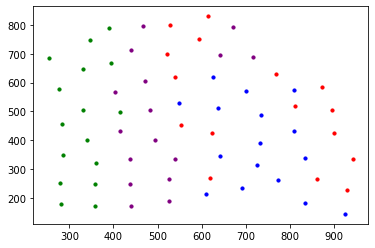

In [70]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in coordCenters0]
yList = [pixelCoord[1] for pixelCoord in coordCenters0]
ax.scatter(xList, yList, s = 10,c = 'blue')

xList = [pixelCoord[0] for pixelCoord in coordCenters1]
yList = [pixelCoord[1] for pixelCoord in coordCenters1]
ax.scatter(xList, yList, s = 10,c = 'red')

xList = [pixelCoord[0] for pixelCoord in coordCenters2]
yList = [pixelCoord[1] for pixelCoord in coordCenters2]
ax.scatter(xList, yList, s = 10,c = 'purple')

xList = [pixelCoord[0] for pixelCoord in coordCenters3]
yList = [pixelCoord[1] for pixelCoord in coordCenters3]
ax.scatter(xList, yList, s = 10,c = 'green')
plt.show()

### Calculate Moran's I distribution using Monte Carlo Simulation on attribute value of each cluster center

In [71]:
import random
zMonteCarlo = zCenters

In [72]:
numMonteCarlo = 10000
moranIList = []
for i in range(numMonteCarlo):
    random.shuffle(zMonteCarlo)
    moranIClusterCenters = moransi(zMonteCarlo, w) # use line grid to decide number of clusters
    moranIList.append(moranIClusterCenters)

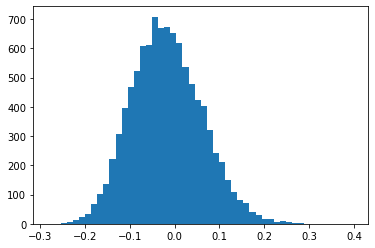

In [73]:
plt.hist(moranIList, 50)
plt.show()

In [74]:
moranIMontArray = np.asarray(moranIList)

In [75]:
moranIMontArrayPercentage25 = np.percentile(moranIMontArray, 2.5)
moranIMontArrayPercentage25

-0.1585242906134819

In [76]:
moranIMontArrayPercentage975 = np.percentile(moranIMontArray, 97.5)
moranIMontArrayPercentage975

0.14547161424672123

In [77]:
moranIMontArrayPercentage5 = np.percentile(moranIMontArray, 5)
moranIMontArrayPercentage5

-0.1376791991486238

In [78]:
moranIMontArrayPercentage95 = np.percentile(moranIMontArray, 95)
moranIMontArrayPercentage95

0.1158972397718246

In [58]:
# expected value
N = len(zCenters)
print(N)
expI = -(1/(N - 1))
# variance
s0 = sum([sum(wRow) for wRow in w])
s1 = 0
for i in range(len(w)):
    for j in range(len(w[0])):
        s1 += (w[i][j] + w[j][i])**2
s1 = s1 /2
s2 = 0
for k in range(N):
    s2kj = 0
    s2ik = 0
    for j in range(N):
        s2kj += w[k][j]
    for i in range(N):
        s2ik += w[i][k]
    s2 += (s2kj + s2ik)**2

36


In [59]:
varI = ((N**2)*s1 - N*s2 + 3*(s0**2))/((N**2 -1)*(s0**2)) - expI**2
sigma = varI**(0.5)

In [60]:
thresholdLower = expI - 2 * sigma
thresholdUpper = expI + 2 * sigma

In [63]:
if moranIClusterCenters < thresholdLower:
    print('Negative spatial autocorrelation')
elif moranIClusterCenters > thresholdUpper:
    print('Positive spatial autocorrelation')
else:
    print('No clear spatial autocorrelation')

Positive spatial autocorrelation
